# A.L.F.R.E.D.

This part of tutorial covers all the aspects of how DEEPNANO are using in our optimization framework ALFRED (Autonomous Learning Framework for Rule-based Evolutionary Design). 

ALFRED consists of two main units: predictor unit (shown as a pink cell) which represents and optimizer unit (shown as bees), which using the predictions from deepnano performs a search in a multidimensional search space. 

The whole purpose of a predictor unit is to effectively approximate an exact response from first principle simulations such as FDTD. Predictor unit in this version of DEEPNANO consists of a complex neural network with convolution base as a universal feature extractor. While this configuration allows us to generate a response from any complex geometrical shapes, for simplicity in this tutorial we used a simple shapes as cuboids in a dataset. In this particular example we used maximum 5 cuboid per period.

As an optimizer unit in this particular example we used a parallel version of so-called Particle Swarm Optimization (PSO) algorithm. 

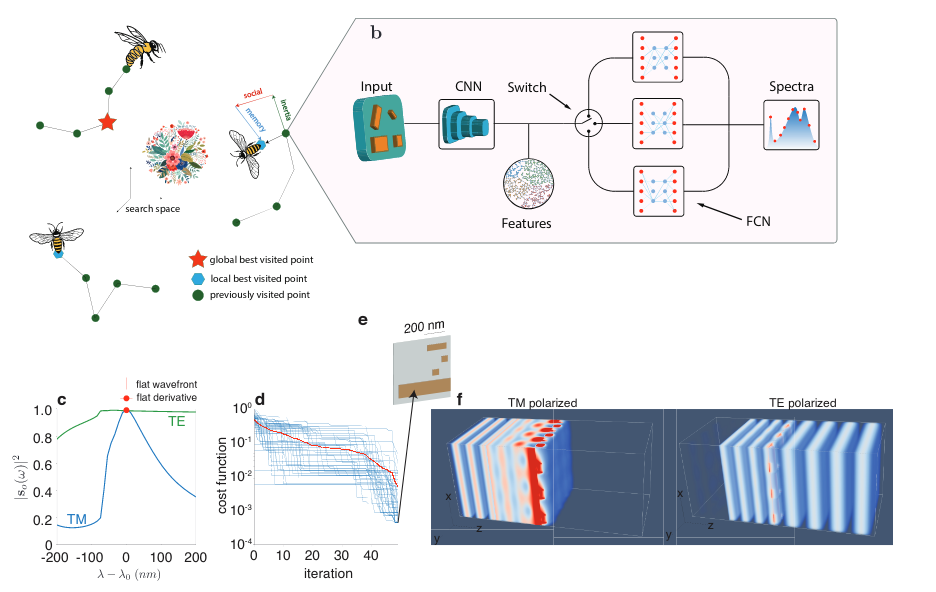

Fig. 1. An example of ALFRED's for a computation of a highly-efficient flat polarizing beam splitter. Optimizer (a) and Predictor (b) units of ALFRED. Desired transmission reflection response (c). Convergence (d) of an optimization process with a target geometry (e). An output from FDTD simulation for TE and TM plane waves (f).

## SET UP

Before we begin let's import all dependencies and define pathes to some key folders. 

REMINDER: All points in masked array has a resolution of 5 nm. So if we specify a global variable MIN_FEATURE_SIZE=10, which means 10 points, that equivalent to fix a minimum shape size in our input masked array at 50 nm. 

In [1]:
#directory with .csv files
DATADIR = 'data/'
#directory with trained models files
MODELDIR = 'data/models/'
#directory with source code
SOURCEDIR = '../'
#directory with all necessary files including mask, dictionary and spectra files
filedir = '/scratch/dragon/intel/makam0a/data/deepnano/data251019/'
MIN_FEATURE_SIZE=10

In [2]:
import numpy as np, os, sys
import matplotlib.pyplot as plt
import matplotlib as ml
from scipy.linalg import norm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import sys
from skimage.transform import resize
from skimage.transform import AffineTransform, warp, rotate
if not os.path.abspath(SOURCEDIR) in sys.path:
    sys.path.append(os.path.abspath(SOURCEDIR))

ModuleNotFoundError: No module named 'PIL'

Let's import and have a closer look on a dataset we are going to use in this tutorial. The dataset consists of an array overlapping input rectangles with a same period and thickness.

In [4]:
data = pd.read_csv(DATADIR + 'data_rect.csv',index_col=0)
nshapes = data.types.map(lambda x: len(x.split('-')))
names = data.index.values 
wxs = data.nx.values
wys = data.ny.values

In [5]:
data.sample(5)

,dz,overlap,types,nx,ny,status
5KDu2VUSwpcDIE1KmOWw,0.1,True,rectangle,100,100,train
u7ymrg2DbZ4zQ2rGEiPI,0.1,False,rectangle-rectangle,100,100,train
AXRVRDDbMaqKiVdEfPKN,0.1,False,rectangle-rectangle,100,100,train
nsv06neBTwR0crRIFh6D,0.1,False,rectangle-rectangle-rectangle,100,100,train
xkZ4SLTv4xo1qM2lt2QH,0.1,False,rectangle-rectangle-rectangle-rectangle,100,100,val


Below is a simple auxillary functions to we will use in this tutorial. Make sure that you understand how it works before we go further. 

In [9]:
def imshow(idx, file=None):
    plt.figure(figsize=[10,5])
    plt.title('mse - %f' % mse(true[idx],pred[idx]))
    _,size = pred.shape
    f = np.linspace(0.3,1.0,size)
    plt.subplot(121)
    plt.plot(f,pred[idx],label='prediction')
    plt.plot(f,true[idx],label='true')
    print(idx,mse(true[idx],pred[idx]))
    plt.ylim(0,1)
    _,size = pred.shape
    plt.legend()
    plt.subplot(122)
    mask = np.fromfile(filedir+names[idx]+'-mask.bin',dtype=np.int32).reshape(int(wxs[idx]),int(wys[idx]))
    plt.imshow(mask)
    if file:
        plt.savefig(file)
        plt.close()
    else:
        plt.show()

# For a given index/token(key) get corresponding masked array
def get_mask(idx=None,token=None, shape=[112,112]):
    if idx is not None:
        mask = np.fromfile(filedir+names[idx]+'-mask.bin',dtype=np.int32).reshape(*shape)
    elif token:
        mask = np.fromfile(filedir+token+'-mask.bin',dtype=np.int32).reshape(*shape)
    return mask

# Standard preprocessing routine 
# for an input mask (padding to a desired network shape, data augmentation and etc.)
def preprocess(mask, input_shape=[224,224],orientation=0,random_translation=False,pad=True,resized=False):
        if orientation:
            mask = rotate(mask,90,preserve_range=True).astype(np.int32)
        if random_translation:
            mask = random_shift(mask, range=mask.shape[0])
        if pad:
            mask = np.pad(mask,pad_width=[(0,input_shape[0]-mask.shape[0]),
                                   (0,input_shape[0]-mask.shape[1])],
                                    mode='constant', constant_values=-1)
            mask = np.expand_dims(mask,axis=-1)
        elif resized:
            image_resized = resize(mask.astype(np.uint8), (input_shape[0], input_shape[1]),anti_aliasing=True)
            image_resized *= 255
            image_resized = image_resized.astype(np.uint8)
            mask = np.expand_dims(image_resized,axis=-1)
        return np.expand_dims(mask,axis=0)

# for a given token(key) get a corresponding ground truth spectra from dataset
def get_spectra(token):
    spectra = np.fromfile(filedir+token+'-spectra.bin',dtype=float).reshape(-1,5)
    wl, te, tm = spectra[:,0], spectra[:,1], spectra[:,2]
    return wl, te, tm

# for a given input mask get a transmission TE/TM prediction  
def predict_spectra(mask, wl0=0.3, wl1=1.0):
    X = preprocess(mask,random_translation=False)
    te = rm.model.predict(X)[0]
    # different orientation for different polarizatons! when this option is 1,
    # it performs 90 degree rotation of an input masked array, along with substituting
    # TE and TM spectra from transmission/reflection dataset
    X = preprocess(mask,random_translation=False,orientation=1)
    tm = rm.model.predict(X)[0]
    wl=np.linspace(wl0,wl1,len(te))
    return wl,te,tm

If you don't have a CUDA compatible GPU or want use only CPU for some reasons, run a cell below.

In [24]:
# Use CPU only
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Predictor

### Load model

First step is to load a trained model. For a trained model we use a model trained on the same dataset based on a ResNet18 architecture. 

In [12]:
from models import ResearchModels
from data import DataSet2 as DataSet
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
from keras import backend as K
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [13]:
model_file = MODELDIR+'resnet18-rect_same_period_100_100%rect_same_period_100_100_corrected-random_translation-False-0.001.hdf5'
saved_model = os.path.join(model_file)
rm=ResearchModels('resnet18',npoints=80,saved_model=saved_model)

Loading model data/models/resnet18-rect_same_period_100_100%rect_same_period_100_100_corrected-random_translation-False-0.001.hdf5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 3136        zero_padding

Let's validate the performance of this model on a test samples. Validation output along with all other temporary files are stored in .tmp/ directory. 

In [ ]:
from validate import validate
indices, X, y = data.get_all_sequences_in_memory('test',with_indices=True)
eval = rm.model.evaluate(X,y)
pred = rm.model.predict(X)
np.save('.tmp/indices',indices)
np.save('./tmp/prediction',pred)
np.save('./tmp/true',y)

Let's have a closer look on a performance of a given model. While average MSE over all the samples are important criteria, what is even more important is how many predictions are considered valid with reasonably low predifined threshold. 

Average MSE 0.001268611295633927
Predictions with MSE greater than treshhold (>0.005) 1.825 %


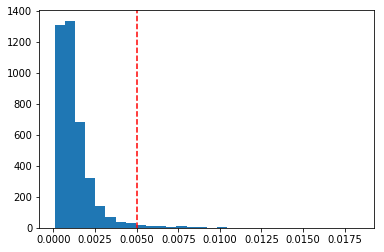

In [15]:
datadir = '.tmp/'
th = 0.005
#fnametemplate="-resnet18-['rect_same_period_100_100']-resnet18-['rect_same_period_100_100', 'rect_same_period_100_100_corrected']-26:11:2019-21:48-random_translation-0-0.001.hdf5.npy"
indices = np.load(datadir+"indices.npy")
pred = np.load(datadir+"prediction.npy")
true = np.load(datadir+"true.npy")
mean_square_error=[]
for idx in range(pred.__len__()):
    mean_square_error.append(mse(true[idx],pred[idx]))
#mean_resnet = mean[:]
mean = np.array(mean_square_error)
print('Average MSE',mean.mean())
print('Predictions with MSE greater than treshhold (>%.3f)' % th, mean[mean>0.005].__len__() / mean.__len__()*100, "%")
plt.hist(mean,bins=30)
plt.axvline(th,c='r', linestyle='--')
plt.show()

Below is a comparision of ground truth spectra with predicted one for a random test sample.

1907 0.00014600399557219


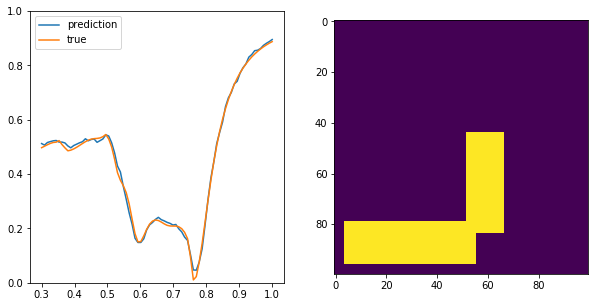

In [17]:
#idx = mean.argsort()[900]
idx = np.random.randint(0,2500)
token = indices[idx]
imshow(idx)
mask = get_mask(token=token,shape=[100,100])
wl, te, tm = predict_spectra(mask)

Below is a comparision of ground truth spectra with a predicted one for a random sample for TE and TM wave.

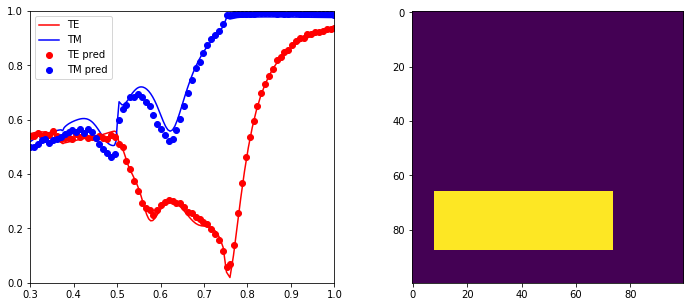

In [25]:
idx = np.random.randint(0,len(true))
token = indices[idx]
plt.figure(figsize=[12,5])
plt.subplot(121)
mask = get_mask(token=token,shape=[100,100])
wl, te, tm = get_spectra(token=token)
plt.xlim(0.3,1.0)
plt.ylim(0,1.0)
plt.plot(wl,te,'r',label='TE')
plt.plot(wl,tm,'b',label='TM')
wl, te, tm = predict_spectra(mask)
plt.plot(wl,te,'ro',label='TE pred')
plt.plot(wl,tm,'bo',label='TM pred')
plt.legend()
plt.subplot(122)
plt.imshow(mask)
plt.show()

To generate a random shapes to get a predictions for a sample which are not represented in dataset we use an auxillary methods from shapes (shapes.py) package. 

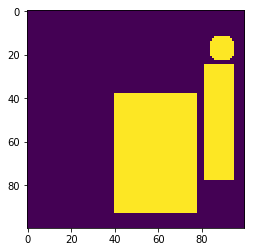

In [28]:
from shapes import generate_random_shapes, Shape, Canvas
import pickle
shape = generate_random_shapes(np.zeros([100,100],dtype=np.int32),types=['rectangle','circle'],max_shapes=4,min_size=MIN_FEATURE_SIZE)
plt.imshow(shape.mask)
plt.show()

Below is a code to generate a prediction from an arbitrary masked input. 

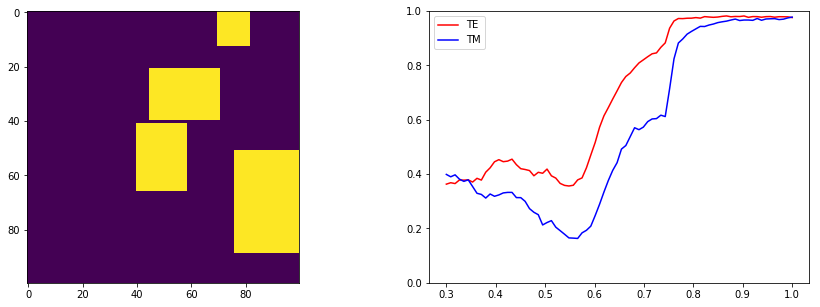

In [31]:
shape = generate_random_shapes(np.zeros([100,100],dtype=np.int32),types=['rectangle'],max_shapes=4,min_size=MIN_FEATURE_SIZE)
mask = shape.mask
wl, te, tm = predict_spectra(mask)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.imshow(shape.mask)
plt.subplot(122)
plt.plot(wl,te,'r',label='TE')
plt.plot(wl,tm,'b',label='TM')
plt.legend()
plt.ylim(0,1)
plt.show()

### Specific layer output

Sometimes it is desired to get an additional output from a specific layer of a neural network model. Below is an example of code performed this task

In [321]:
from keras import backend as K
from sklearn.manifold import TSNE

In [339]:
idx = 0
layer_of_interest = -7
intermediate_tensor_function = K.function([rm.model.layers[0].input],[rm.model.layers[layer_of_interest].output])
mask = get_mask(idx,shape=[100,100])
X = preprocess(mask,random_translation=False)
intermediate_tensor = intermediate_tensor_function([X])

In [340]:
intermediate_tensor[0][0].shape

(7, 7, 512)